# Classification of Tumor Samples using Gene Expression Data
* Caitlin Dresibach
* Elizabeth Homan
* Morgan Wall

### Coding References: 
* https://gist.github.com/bistaumanga/6023716
* https://github.com/ubdsgroup/ubmlcourse/blob/master/notebooks/MixtureModels.ipynb

## Import Libraries and Read in the Data

In [1]:
import numpy as np
import pandas as pd
import requests
import string as st
import os
import csv
import re
import random
import csv
import math

#For general + logistic regression
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

#For EM
import scipy.stats as st
from scipy.stats import norm,bernoulli
from scipy.optimize import minimize, show_options
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

#For naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

#For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Set path for files (data, labels, and gene rankings), assuming you are in the correct directory
data = 'data.csv'
labels = 'labels.csv'
rankings = 'rferankings10.txt'

In [3]:
#Read in data
df1 = pd.read_csv(data, encoding= "ISO-8859-1", low_memory=False)

In [4]:
#Read in labels
labels = pd.read_csv(labels, encoding= "ISO-8859-1", low_memory=False)

In [5]:
#Read in rankings
ranks = pd.read_table(rankings, encoding= "ISO-8859-1", low_memory=False, header = None)

## Preprocessing and Data Exploration

In [6]:
df1.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [7]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [8]:
#Add the class labels to the gene expression data
df1["Class"] = labels["Class"]

In [9]:
#Drop first unnecessary column
df2 = df1.drop("Unnamed: 0", axis=1)

In [10]:
df2.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [11]:
df2.isnull().sum().sum() #No missing values

0

In [12]:
df2["Class"].dtypes #Class data is all of object datatype

dtype('O')

In [13]:
#Reassign class data as categorical
df2["Class"] = df2["Class"].astype('category')

In [14]:
df2["Class"].dtypes

CategoricalDtype(categories=['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], ordered=False)

In [15]:
df2["gene_2"].dtypes #Gene data is of the appropriate type

dtype('float64')

In [16]:
#Set x equal to gene expression data columns
x = df2.loc[:,:"gene_20530"]

In [17]:
#Set y equal to target data column (tumor classes)
y = df2.loc[:,"Class"]

## Splitting Testing and Training

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [19]:
x_train.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
159,0.0,3.755902,4.589122,6.440992,9.438946,0.0,8.335864,0.560128,0.0,0.0,...,5.667046,8.342204,10.147587,6.502369,9.999013,12.114276,10.344673,9.110374,5.013878,0.0
337,0.0,2.683337,2.982327,7.381655,10.126149,0.0,7.664561,0.887603,0.0,0.0,...,6.338184,9.942045,10.217049,5.470976,9.274786,11.685511,11.121378,9.343414,4.203702,0.0
77,0.0,0.000000,3.193236,5.329328,10.415277,0.0,9.464960,1.602504,0.0,0.0,...,4.484454,7.517913,10.505970,6.003074,9.110966,11.380445,8.939041,8.730046,3.724650,0.0
651,0.0,3.391204,3.313725,7.066369,9.295190,0.0,8.349126,0.535655,0.0,0.0,...,6.379971,9.071114,10.190158,5.493926,9.874213,12.310908,10.311499,9.783647,8.501881,0.0
283,0.0,3.188433,3.802876,5.223307,10.039467,0.0,8.277924,0.712464,0.0,0.0,...,5.441779,8.521754,10.124044,6.462131,9.511608,11.523645,9.764497,8.457689,6.508402,0.0


In [20]:
y_train.head()

159    LUAD
337    BRCA
77     KIRC
651    BRCA
283    LUAD
Name: Class, dtype: category
Categories (5, object): [BRCA, COAD, KIRC, LUAD, PRAD]

## Logistic Regression

In [21]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
preds = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [23]:
preds

array(['BRCA', 'BRCA', 'PRAD', 'BRCA', 'BRCA', 'BRCA', 'LUAD', 'BRCA',
       'KIRC', 'BRCA', 'COAD', 'KIRC', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'LUAD', 'LUAD', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'PRAD', 'LUAD',
       'LUAD', 'KIRC', 'COAD', 'PRAD', 'LUAD', 'BRCA', 'LUAD', 'BRCA',
       'LUAD', 'KIRC', 'COAD', 'KIRC', 'BRCA', 'KIRC', 'LUAD', 'COAD',
       'LUAD', 'PRAD', 'LUAD', 'KIRC', 'BRCA', 'PRAD', 'BRCA', 'KIRC',
       'KIRC', 'BRCA', 'KIRC', 'BRCA', 'PRAD', 'PRAD', 'PRAD', 'PRAD',
       'BRCA', 'PRAD', 'BRCA', 'BRCA', 'COAD', 'PRAD', 'BRCA', 'KIRC',
       'PRAD', 'BRCA', 'KIRC', 'KIRC', 'COAD', 'PRAD', 'LUAD', 'COAD',
       'BRCA', 'BRCA', 'LUAD', 'BRCA', 'BRCA', 'BRCA', 'COAD', 'LUAD',
       'BRCA', 'COAD', 'KIRC', 'LUAD', 'LUAD', 'BRCA', 'PRAD', 'BRCA',
       'KIRC', 'PRAD', 'BRCA', 'BRCA', 'KIRC', 'LUAD', 'LUAD', 'LUAD',
       'BRCA', 'PRAD', 'KIRC', 'BRCA', 'BRCA', 'LUAD', 'PRAD', 'BRCA',
       'PRAD', 'KIRC', 'KIRC', 'LUAD', 'LUAD', 'BRCA', 'COAD', 'KIRC',
      

In [24]:
y_test

8      BRCA
253    BRCA
85     PRAD
406    BRCA
14     BRCA
439    BRCA
706    LUAD
454    BRCA
718    KIRC
522    BRCA
79     COAD
103    KIRC
402    BRCA
476    BRCA
175    BRCA
27     BRCA
344    LUAD
150    LUAD
200    BRCA
420    BRCA
250    BRCA
285    BRCA
390    PRAD
241    LUAD
636    LUAD
270    KIRC
732    COAD
477    PRAD
759    LUAD
630    BRCA
       ... 
170    KIRC
187    LUAD
722    BRCA
380    KIRC
45     BRCA
587    PRAD
354    COAD
62     BRCA
78     PRAD
756    BRCA
382    COAD
303    LUAD
140    BRCA
198    LUAD
345    LUAD
570    COAD
127    BRCA
261    COAD
415    BRCA
781    KIRC
144    LUAD
214    PRAD
662    COAD
374    PRAD
21     KIRC
717    PRAD
628    KIRC
590    COAD
35     BRCA
81     PRAD
Name: Class, Length: 241, dtype: category
Categories (5, object): [BRCA, COAD, KIRC, LUAD, PRAD]

In [25]:
x.shape #20531 genes

(801, 20531)

## Recursive Feature Elimination / Using Ranked Genes

In [26]:
#Feature selection -- completed on Rivanna

#rfe = RFE(logreg, 100)
#rfe = rfe.fit(x_train, y_train)
#print(rfe.support_)
#print(rfe.ranking_)

In [27]:
ranks.head()

,0
0,19747
1,16579
2,10421
3,7377
4,14640


In [28]:
#Create a list of the top 10 genes based on the RFE results, to use for subsetting the full dataset
ranks2 = ranks[ranks[0] == 1]
ranks2.index.name = 'topgenes'
ranks2.reset_index(inplace=True)
ranks2.head()
top_genes = ranks2['topgenes'].tolist()
top_genes.append(20531) # keep the class column
top_genes

[3523, 3541, 3921, 6733, 6876, 7623, 7964, 8598, 9175, 15898, 20531]

In [29]:
#Take a subset of the data including all observations, but only the top 10 genes and the class labels
df3 = df2.iloc[:,top_genes]
print(df3.shape)
print(df3.columns)

(801, 11)
Index(['gene_3523', 'gene_3541', 'gene_3921', 'gene_6733', 'gene_6876',
       'gene_7623', 'gene_7964', 'gene_8598', 'gene_9175', 'gene_15898',
       'Class'],
      dtype='object')


In [30]:
#Define x and y (features and classes)
x = df3.iloc[:,:10]
y = df3.loc[:,"Class"]
x.head()

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
0,1.822037,5.788312,0.591871,2.717803,8.440400,5.663951,5.248778,7.210184,17.173570,1.334282
1,1.327170,13.059513,0.587845,2.592278,6.484409,0.000000,3.890826,2.762370,0.000000,13.609213
2,2.438799,5.155361,0.796598,1.306846,3.352236,1.306846,1.074163,3.677147,14.818422,1.074163
3,1.039419,5.983377,0.000000,0.000000,5.967242,0.000000,2.650029,7.226961,17.371079,0.434882
4,2.678342,8.349648,1.095654,0.360982,13.636772,5.024776,0.000000,10.982102,1.580097,1.095654


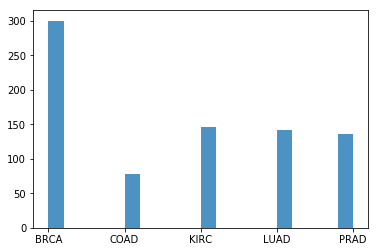

In [31]:
#View a distribution of the class labels
h1 = plt.hist(np.array(df2["Class"]), bins=20,normed=False,histtype='stepfilled',alpha=0.8); 

## Logistic Regression with 10 or Fewer Genes

In [32]:
#Re-split data with the 10 selected genes from above (x and y have been reassigned)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [33]:
x_train.head()

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
159,3.180227,15.871352,2.111265,3.390626,6.913428,0.962586,9.468229,6.884757,0.962586,16.784098
337,3.182009,7.498171,0.510962,2.392400,13.091333,4.268771,0.000000,10.001282,1.185930,2.608904
77,1.602504,1.602504,9.651880,16.501178,5.310940,0.000000,11.544849,7.580658,0.000000,0.000000
651,4.438526,7.183228,2.335369,2.677102,12.890488,7.462380,0.000000,10.075800,3.254473,0.925468
283,0.399773,13.041993,1.543842,2.533389,4.400190,0.000000,9.976407,9.330289,0.712464,20.177309


In [34]:
x_train.shape #Note that there are only 10 columns, one for each of the top ranked genes

(560, 10)

In [35]:
#Fit model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
preds = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
#Still has 100% accuracy!

Accuracy of logistic regression classifier on test set: 1.00


In [37]:
#Use feature selection to rank WITHIN the top 10 genes (Rivanna did not do this - it ranked all the top ten equally)
rfe = RFE(logreg, 1)
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True False False False]
[ 2  4  9 10  3  7  1  8  5  6]


In [38]:
#Select top 5 genes
x = df3.iloc[:,[6,0,4,8,9]]
y = df3.loc[:,"Class"]
x.head()

,gene_7964,gene_3523,gene_6876,gene_9175,gene_15898
0,5.248778,1.822037,8.440400,17.173570,1.334282
1,3.890826,1.327170,6.484409,0.000000,13.609213
2,1.074163,2.438799,3.352236,14.818422,1.074163
3,2.650029,1.039419,5.967242,17.371079,0.434882
4,0.000000,2.678342,13.636772,1.580097,1.095654


In [39]:
#Resplit testing/training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [40]:
x_train.head()

,gene_7964,gene_3523,gene_6876,gene_9175,gene_15898
159,9.468229,3.180227,6.913428,0.962586,16.784098
337,0.000000,3.182009,13.091333,1.185930,2.608904
77,11.544849,1.602504,5.310940,0.000000,0.000000
651,0.000000,4.438526,12.890488,3.254473,0.925468
283,9.976407,0.399773,4.400190,0.712464,20.177309


In [41]:
#Fit newest model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
preds = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
#STILL 100% accurate!

Accuracy of logistic regression classifier on test set: 1.00


In [43]:
#Repeat above steps for top 4 genes
x = df3.iloc[:,[6,0,4,8]]
y = df3.loc[:,"Class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
preds = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
#96% accurate

Accuracy of logistic regression classifier on test set: 0.96


In [44]:
#Repeat above steps for top 4 genes
x = df3.iloc[:,[6,0,4]]
y = df3.loc[:,"Class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
preds = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
#87% accurate

Accuracy of logistic regression classifier on test set: 0.87


## Expectation Maximization Set Up 


In [45]:
#Re-define x and y (features and classes)
x = df3.iloc[:,:10]
y = df3.loc[:,"Class"]
x.head()

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
0,1.822037,5.788312,0.591871,2.717803,8.440400,5.663951,5.248778,7.210184,17.173570,1.334282
1,1.327170,13.059513,0.587845,2.592278,6.484409,0.000000,3.890826,2.762370,0.000000,13.609213
2,2.438799,5.155361,0.796598,1.306846,3.352236,1.306846,1.074163,3.677147,14.818422,1.074163
3,1.039419,5.983377,0.000000,0.000000,5.967242,0.000000,2.650029,7.226961,17.371079,0.434882
4,2.678342,8.349648,1.095654,0.360982,13.636772,5.024776,0.000000,10.982102,1.580097,1.095654


In [46]:
#Create a subset of the full dataset for each tumor type (to be used for selecting a random point
# from each class)

df_prad = df3.loc[df3["Class"] == "PRAD", :]
df_luad = df3.loc[df3["Class"] == "LUAD", :]
df_brca = df3.loc[df3["Class"] == "BRCA", :]
df_kirc = df3.loc[df3["Class"] == "KIRC", :]
df_coad = df3.loc[df3["Class"] == "COAD", :]

In [47]:
#Basic Dimensions

n = 801  #number of samples
d = 10   #number of features
k = 5    #number of clusters


### Initialize the Means (mu)

In [48]:
#Choose a random datapoint from each cluster to be the starting mean
mu = []
dfs = [df_prad, df_luad, df_brca, df_kirc, df_coad]
for i in range(5):
    mu_ = dfs[i].iloc[np.random.choice(range(len(dfs[i])), 1, False), :]
    mu.append(mu_)

mu_df = pd.DataFrame(columns = dfs[1].columns)
for i in range(len(mu)):
    mu_df = pd.concat([mu_df, mu[i]])
mu = mu_df.iloc[:, 0:10]
mu

#Rename the rows
mu.index = ["PRAD", "LUAD", "BRCA", "KIRC", "COAD"]
mu

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
PRAD,1.413540,5.150795,0.000000,4.577640,7.966753,2.855910,7.089488,6.655833,17.974162,0.501821
LUAD,2.304920,16.439909,1.088209,1.427177,4.018162,0.000000,8.628289,9.877671,1.931797,16.812578
BRCA,2.199908,7.678142,0.000000,0.781486,13.092475,3.801190,0.443076,9.066697,0.781486,1.055473
KIRC,1.695103,0.000000,10.768275,13.519391,4.714674,0.000000,9.988841,3.447751,3.219200,0.400210
COAD,12.277282,15.352823,10.142299,0.000000,2.258911,1.979989,9.485888,4.086317,0.000000,0.880803


### Initialize the Covariance (sigma)

In [49]:
#Initialize the covariance matrices as identity matrices for each cluster with dimensions dxd
sigma = [np.eye(d)] * k

### Initialize the Class Probabilities

In [50]:
#Initialize pi- probability of each class

pi_ = [1./k] * k #equally probable
pi_

[0.2, 0.2, 0.2, 0.2, 0.2]

### Initialize the Responsibility Matrix

In [51]:
#Initialize the responsibility function as 0
gamma = np.zeros((n, k))
gamma.shape

(801, 5)

### Define the Probability Distribution Functions
* PDF is the probability of the class of x given theta.  
* mixPDF = sum over all classes [the probability of the class * distribution of the class]
* responsibility function for each sample = PDFk/mixPDF

In [52]:
# define the Probability Distribution Function to be used in the E- step 
# for computing the responsibility function. 

PDF = lambda mu, sigma: np.linalg.det(sigma) ** -.5 ** (2*np.pi) ** (-n/2.)\
        * np.exp(-.5 *np.einsum('ij, ij -> i', x - mu, np.dot(np.linalg.inv(sigma), \
        (x-mu).T).T))

## Run the Expectation Maximization

In [53]:
#initialize a loop

log_likelihoods = []
theta_learning = []
means = []
covar = []
probs = []
threshold = 0.0001
max_iter = 10000
counter = 0
converged = False

while not converged: 
    counter += 1 
    for k_value in range(k):
        
        #-- E- Step
        #---- calculate the responsibility function
        gamma[:, k_value] = pi_[k_value] * PDF(mu.iloc[k_value], sigma[k_value])

        #---- calculate the log likelihood
    log_likelihood = np.sum(np.log(np.sum(gamma, axis = 1)))
    log_likelihoods.append(log_likelihood)

    #---- normalize so that the responsibility matrix is row stochastic
    gamma = (gamma.T /np.sum(gamma, axis = 1)).T

    #---- determine the number of datapoints falling into each distribution
    N_ks = np.sum(gamma, axis = 0)

    for k_value in range(k):
        #-- M- Step
        #---- calculate the new parameters for each Gaussian

        mu.iloc[k_value] = (np.sum(gamma[:, k_value]* x.T, axis = 1).T) / N_ks[k_value]
        x_mu = np.matrix(x- mu.iloc[k_value])

        sigma[k_value] = np.array(np.dot(np.multiply(x_mu.T, gamma[:, k_value]), x_mu)/ N_ks[k_value])

        pi_[k_value] = 1./ n*N_ks[k_value]

    #-- track progress
    theta0 = namedtuple('theta0', ['mu', 'sigma', 'pi_', 'log_likelihood', 'iterations'])
    theta0.mu = mu
    theta0.sigma = sigma
    theta0.pi_ = pi_
    theta0.log_likelihood = log_likelihoods
    theta0.iterations = len(log_likelihoods)
    
    theta_learning.append(theta0)
    means.append(mu)
    covar.append(sigma)
    probs.append(pi_)
    
    
    #-- check for convergence
    if len(log_likelihoods) < 2 : continue
    if np.abs(log_likelihood - log_likelihoods[-2])< threshold: break
    
    # or reached max iterations? 
    converged = counter >= max_iter 
    
params = namedtuple('params', ['mu', 'sigma', 'pi_', 'log_likelihoods', 'num_iters'])
params.mu = mu
params.sigma = sigma
params.pi_ = pi_
params.log_likelihoods = log_likelihoods
params.num_iters = len(log_likelihoods)  
        
print(len(log_likelihoods))
    


10


### View Resulting Parameters

In [54]:
print(params.mu.iloc[0:10, :])
print(params.pi_)

      gene_3523  gene_3541  gene_3921  gene_6733  gene_6876  gene_7623  \
PRAD   1.340056   5.349057   0.731911   1.751508   6.882429   2.558045   
LUAD   2.663056  14.221523   2.062452   3.545810   6.216142   0.596140   
BRCA   2.559152   9.005241   1.056061   1.570172  12.766649   4.679141   
KIRC   1.488447   0.825130   9.576211  12.981462   6.343440   0.280535   
COAD  11.817061  14.480650   9.820895   2.350674   4.530450   4.390389   

      gene_7964  gene_8598  gene_9175  gene_15898  
PRAD   6.735686   6.530793  16.752979    0.742696  
LUAD   8.575348   7.560904   0.874444   15.592440  
BRCA   0.357832   9.957025   1.615781    1.070110  
KIRC  11.162369   6.488361   0.363720    1.078570  
COAD   9.104005   3.601341   1.054822    1.382390  
[0.16978822064109725, 0.17728280109164282, 0.37327854131600685, 0.18227215979769515, 0.09737827715355805]


## Use the Distributions from EM to Predict the Class Labels

In [55]:
#Define a function that predicts the probability of each class for each observation using the 
# distribution parameters from the EM model
def predict(x, k):
    p = np.linalg.det(sigma[k]) ** - 0.5 * (2 * np.pi) **\
        (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu.iloc[k] , \
        np.dot(np.linalg.inv(sigma[k]) , (x - mu.iloc[k]).T)))
    prob = pi_[k]*p
    return(prob)

In [56]:
#Create a dataframe to store the predicted probabilites for each class
prob_df = pd.DataFrame(index = np.arange(801), columns = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'])

In [57]:
#Calculate the probabilities of each class for each observation
prob_df['PRAD'] = predict(x, 0)
prob_df['LUAD'] = predict(x, 1)
prob_df['BRCA'] = predict(x, 2)
prob_df['KIRC'] = predict(x, 3)
prob_df['COAD'] = predict(x, 4)

In [58]:
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD
0,3.458460e-323,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,2.583963e-321,1.563772e-318,0.000000e+00,1.284972e-306,0.0
2,1.047419e-321,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,7.855644e-322,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,3.606679e-322,0.000000e+00,2.156102e-320,0.000000e+00,0.0


In [59]:
#Take the sum of all of the calculated class probabilities

for i in range(len(prob_df)):
    prob_df.loc[i, 'sum'] = sum(prob_df.iloc[i, 0:5])
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum
0,3.458460e-323,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.458460e-323
1,2.583963e-321,1.563772e-318,0.000000e+00,1.284972e-306,0.0,1.284972e-306
2,1.047419e-321,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.047419e-321
3,7.855644e-322,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.855644e-322
4,3.606679e-322,0.000000e+00,2.156102e-320,0.000000e+00,0.0,2.192169e-320


In [60]:
#Divide the probability of each class geiven theta by the sum of the probabilities to get the 
# normalized probability

prob_df["PRAD"] = prob_df["PRAD"]/prob_df['sum']
prob_df["LUAD"] = prob_df["LUAD"]/prob_df['sum']
prob_df["BRCA"] = prob_df["BRCA"]/prob_df['sum']
prob_df["KIRC"] = prob_df["KIRC"]/prob_df['sum']
prob_df["COAD"] = prob_df["COAD"]/prob_df['sum']
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum
0,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,3.458460e-323
1,2.010910e-15,1.216969e-12,0.000000,1.0,0.0,1.284972e-306
2,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.047419e-321
3,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,7.855644e-322
4,1.645256e-02,0.000000e+00,0.983547,0.0,0.0,2.192169e-320


In [61]:
#Predict the class of each observation by finding the class with the highest probability for each obs.
prob_df['pred'] = prob_df.iloc[:, 0:5].idxmax(axis = 1)
print(prob_df['pred'].value_counts())
print(y.value_counts())

PRAD    391
BRCA    203
KIRC    160
LUAD     31
COAD     16
Name: pred, dtype: int64
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64


In [62]:
#Initialize columns for the ground truth label and an indicator of whether the prediction is correct
prob_df['groundtruth'] = y
prob_df['correct'] = np.nan

In [63]:
#Determine the accuracy

for i in range(801):
    if prob_df.loc[i, 'pred'] == prob_df.loc[i, 'groundtruth']:
        prob_df.loc[i, 'correct'] = 1
    else: 
        prob_df.loc[i, 'correct'] = 0
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum,pred,groundtruth,correct
0,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,3.458460e-323,PRAD,PRAD,1.0
1,2.010910e-15,1.216969e-12,0.000000,1.0,0.0,1.284972e-306,KIRC,LUAD,0.0
2,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.047419e-321,PRAD,PRAD,1.0
3,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,7.855644e-322,PRAD,PRAD,1.0
4,1.645256e-02,0.000000e+00,0.983547,0.0,0.0,2.192169e-320,BRCA,BRCA,1.0


In [64]:
#Find the total number of correct predictions

total_correct = sum(prob_df['correct'])
total_correct

404.0

In [65]:
#Calculate the percentage of correct observations

print('Accuracy of Expectation Maximization classifier on test set: {:.2f}'.format(total_correct/len(prob_df)))

Accuracy of Expectation Maximization classifier on test set: 0.50


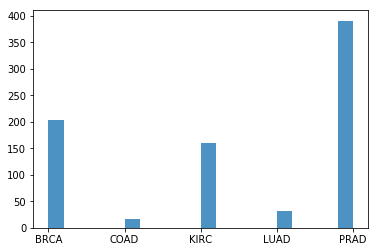

In [66]:
# show distribution of EM predictions
h1 = plt.hist(np.array(prob_df["pred"]), bins=20,normed=False,histtype='stepfilled',alpha=0.8); 

## Bayes Classifier

In [67]:
#Reassign x and y to full original dataset/labels
x = df2.loc[:,:"gene_20530"]
y = df2.loc[:,"Class"]

In [68]:
# Scale the data to be between -1 and 1
scaler = StandardScaler()
X=scaler.fit_transform(x)
X

array([[-0.19479935, -0.82802988,  0.15980044, ..., -1.18793812,
        -0.11648251, -0.26190144],
       [-0.19479935, -2.01501735, -1.415042  , ..., -0.34227662,
        -1.65688871, -0.26190144],
       [-0.19479935,  0.41734754,  1.15673547, ...,  0.88686027,
        -1.85526414, -0.26190144],
       ...,
       [-0.19479935,  0.19888076,  0.57481583, ..., -0.22008186,
        -0.41046699,  1.3485582 ],
       [-0.19479935, -0.35045311, -0.28863152, ...,  1.43719268,
         0.09195083, -0.26190144],
       [-0.19479935, -0.57135218,  0.66725377, ...,  0.45087581,
        -0.47161901, -0.26190144]])

In [69]:
#Split testing/training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Gaussian Naive Bayes


In [70]:
#Chose the naive bayes model for comparison
model_naive = GaussianNB()
model_naive.fit(X_train, Y_train)

GaussianNB(priors=None)

In [71]:
#Compute the positive class predicition probabilities 
y_prob = model_naive.predict_proba(X_test)[:,1] 
y_pred = np.where(y_prob > 0.5, 1, 0) 
model_naive.score(X_test, y_pred)

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [72]:
#Compute accuracy scores with cross validation
scores = cross_val_score(model_naive, X, y, cv=10, scoring='accuracy')
print(scores)

[0.74390244 0.71604938 0.61728395 0.61728395 0.61728395 0.69135802
 0.6835443  0.65822785 0.73076923 0.66666667]


In [73]:
#Find the mean of the scores
scores.mean()

0.6742369747618282

### Bernoulli Naive Bayes 

In [74]:
model_naive_b = BernoulliNB()
model_naive_b.fit(X_train, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [75]:
#Compute the positive class predicition probabilities 
y_prob = model_naive_b.predict_proba(X_test)[:,1] 
y_pred = np.where(y_prob > 0.5, 1, 0) 
model_naive.score(X_test, y_pred)

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [76]:
#Compute accuracy scores with cross validation
scores_b = cross_val_score(model_naive_b, X, y, cv=10, scoring='accuracy')
print(scores_b)

[0.97560976 0.98765432 0.98765432 0.98765432 0.97530864 1.
 1.         0.97468354 0.98717949 0.94871795]


In [77]:
#Find the mean of the scores
scores_b.mean()

0.9824462341237066